In [ ]:
from google.colab import userdata
import os
os.environ["HF_TOKEN"] = userdata.get('HF_TOKEN')

In [ ]:
!pip install accelerate datasets transformers datasets nltk rouge-score bert-score nltk transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 9.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.

# Generation of the ORPO Dataset

In [ ]:
import os
import json
import random
import pandas as pd
import re
import torch
import transformers
import logging

# Configure logging
logger = logging.getLogger('simulation')  # Create a logger named 'simulation'
logger.setLevel(logging.DEBUG) # Set logging level to DEBUG
file_handler = logging.FileHandler('/content/drive/MyDrive/simulation.log', 'a', 'utf-8') # Create a file handler to log messages to a file
file_handler.setLevel(logging.DEBUG) # Set file handler logging level to DEBUG
file_handler.setFormatter(logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')) # Set log message format
file_handler.terminator = ''  # Remove the default newline terminator
logger.addHandler(file_handler) # Add the file handler to the logger

class Simulation:
    def __init__(self, tasks, output_filepath):
        """
        Initialize the Simulation class.

        Parameters:
        tasks (dict): A dictionary of task weights.
        output_filepath (str): The file path where output will be saved.
        """
        self.tasks = tasks # Dictionary of task weights
        self.json_records = [] # List to store JSON records
        self.output_filepath = output_filepath # Output file path for saving results
        self.total_files = 0 # Counter for total files processed
        self.successful_tasks = 0 # Counter for successful tasks
        self.parsing_errors = 0 # Counter for parsing errors
        self.backup_errors = 0 # Counter for backup errors
        self.runtime_errors = 0 # Counter for runtime errors
        self.successful_saves = 0 # Counter for successful saves

    def parse_json_garbage(self, s, source=None):
        """
        Parse a potentially malformed JSON string.

        Parameters:
        s (str): The input string containing JSON.
        source (str, optional): The source of the JSON data.

        Returns:
        dict: The parsed JSON object.
        """
        logging.debug("Parsing JSON garbage.")
        try:
            json_start = next((idx for idx, c in enumerate(s) if c in "{["), None) # Find the start of the JSON object
            if json_start is None:
                raise ValueError("No JSON object found in the input string")

            s = s[json_start:] # Extract the JSON string
            s = re.sub(r'[\x00-\x1f\x7f-\x9f]', '', s) # Remove control characters

            try:
                json_end = max(s.rfind('}'), s.rfind(']')) + 1 # Find the end of the JSON object and parse it
                parsed_json = json.loads(s[:json_end])
            except json.JSONDecodeError as e:
                logging.error(f"JSON decode error: {e}")
                try:
                    parsed_json = json.loads(s[:e.pos]) # Attempt to parse up to the error position
                except json.JSONDecodeError as inner_e:
                    logging.error(f"Inner JSON decode error: {inner_e}")
                    cleaned_s = s[:e.pos].rsplit(',', 1)[0] + ']}'
                    try:
                        parsed_json = json.loads(cleaned_s) # Attempt to parse a cleaned version of the string
                    except json.JSONDecodeError as final_e:
                        logging.error(f"Final JSON decode error: {final_e}")
                        raise final_e

            if source:
                parsed_json["source"] = source # Add source to the parsed JSON

            for key in ["source", "chosen", "rejected", "prompt", "question"]:
                if key not in parsed_json:
                    parsed_json[key] = None

            return parsed_json
        except Exception as e:
            logging.error(f"Unexpected error in parse_json_garbage: {e}")
            raise e


    def pipe(self, messages, model_id):
        """
        Generate text using a transformer model pipeline.

        Parameters:
        messages (list): A list of messages for the model.
        model_id (str): The ID of the model to use.

        Returns:
        str: The generated text.
        """
        logging.debug(f"Running pipeline for model {model_id}.")
        pipeline = transformers.pipeline(
            "text-generation",
            model=model_id,
            model_kwargs={"torch_dtype": torch.bfloat16},
            device_map="auto",
        )

        terminators = [
            pipeline.tokenizer.eos_token_id,
            pipeline.tokenizer.convert_tokens_to_ids("<|eot_id|>")
        ]

        outputs = pipeline(
            messages,
            max_new_tokens=pipeline.tokenizer.model_max_length,
            eos_token_id=terminators,
            do_sample=True,
            temperature=0.6,
            top_p=0.9,
        )
        logging.debug(f"Generated text: {outputs[0]['generated_text'][-1]['content']}")
        return(outputs[0]["generated_text"][-1]["content"])

    def message_maker(self, prompt, inhoud):
        """
        Create a list of messages for the pipeline.

        Parameters:
        prompt (str): The system prompt message.
        inhoud (str): The user content message.

        Returns:
        list: A list of message dictionary.
        """
        logging.debug("Creating messages for the pipeline.")
        messages = [
            {"role": "system", "content": prompt},
            {"role": "user", "content": inhoud},
        ]
        return messages

    def common_task(self, bestandsnaam, inhoud, prefix):
        """
        Perform a common task using a specified prefix.

        Parameters:
        bestandsnaam (str): The name of the file.
        inhoud (str): The content of the file.
        prefix (str): The prefix for selecting prompt files.

        Returns:
        dict: The parsed JSON object generated from the task.
        """
        logging.info(f"Starting common task with prefix {prefix} for file {bestandsnaam}.")
        map_pad = 'input/prompts'
        bestanden = [f for f in os.listdir(map_pad) if f.startswith(prefix) and f.endswith('.txt')]
        willekeurig_bestand = random.choice(bestanden)
        bestandspad = os.path.join(map_pad, willekeurig_bestand)
        with open(bestandspad, 'r', encoding='utf-8') as bestand:
            system = bestand.read()
        messages = self.message_maker(system, inhoud)
        generated = self.pipe(messages, "meta-llama/Meta-Llama-3-8B-Instruct")
        parsed_json = self.parse_json_garbage(generated, bestandsnaam)
        return parsed_json

    def afmaken(self, bestandsnaam, inhoud):
        return self.common_task(bestandsnaam, inhoud, 'schrijven_') # Complete a task with the 'schrijven_' prefix.

    def samenvatten(self, bestandsnaam, inhoud):
        return self.common_task(bestandsnaam, inhoud, 'samenvatten_') # Complete a task with the 'samenvatten_' prefix.

    def organiseren(self, bestandsnaam, inhoud):
        return self.common_task(bestandsnaam, inhoud, 'organiseren_') # Complete a task with the 'organiseren_' prefix.

    def vraag_antwoord(self, bestandsnaam, inhoud):
        return self.common_task(bestandsnaam, inhoud, 'vraagantwoord_') # Complete a task with the 'vraagantwoord_' prefix.

    def rolinnemen(self, bestandsnaam, inhoud):
        return self.common_task(bestandsnaam, inhoud, 'rolinnemen_') # Complete a task with the 'rolinnemen_' prefix.

    def backup(self, bestandsnaam, inhoud):
            """
            Perform a backup task if the main task fails.

            Parameters:
            bestandsnaam (str): The name of the file.
            inhoud (str): The content of the file.

            Returns:
            dict: The parsed JSON object generated from the backup task.
            """
            logging.info(f"Running backup task for file {bestandsnaam}.")
            system = """
            Stel een prompt samen die als eerste zin dient voor een gesprek tussen een mens en LLM. Maak de prompt op aan de hand van de txt. Je moet alleen de volgende JSON aanvullen en in het Nederlands.
            {
                "prompt": ...
            }
            ```json
            """
            messages = self.message_maker(system, inhoud)
            json_prompt = self.pipe(messages, "meta-llama/Meta-Llama-3-8B-Instruct")

            try:
                data = self.parse_json_garbage(json_prompt, bestandsnaam)
            except (ValueError, json.JSONDecodeError) as e:
                logging.error(f"Backup JSON decode error: {e}")
                return None

            prompt = data.get("prompt", "")
            if not prompt:
                logging.warning(f"No prompt found in parsed JSON for file {bestandsnaam}.")
                return None

            messages = self.message_maker(prompt + " In het Nederlands graag.", inhoud)
            answer = self.pipe(messages, "meta-llama/Meta-Llama-3-8B-Instruct")
            rejected = self.pipe(messages, "microsoft/Phi-3-mini-4k-instruct")

            orpo = {
                "source": bestandsnaam,
                "chosen": [
                    {
                        "content": prompt,
                        "role": "user"
                    },
                    {
                        "content": answer,
                        "role": "assistant"
                    }
                ],
                "rejected": [
                    {
                        "content": prompt,
                        "role": "user"
                    },
                    {
                        "content": rejected,
                        "role": "assistant"
                    }
                ],
                "prompt": prompt,
                "question": prompt
            }
            return orpo

    def save_record(self, record):
            """
            Save a record to a parquet file.

            Parameters:
            record (dict): The record to be saved.

            Returns:
            None
            """
            df = pd.DataFrame([record], columns=["source", "chosen", "rejected", "prompt", "question"])
            if os.path.exists(self.output_filepath):
                existing_df = pd.read_parquet(self.output_filepath)
                df = pd.concat([existing_df, df])
            df.to_parquet(self.output_filepath, index=False)
            self.successful_saves += 1
            torch.cuda.empty_cache()
            torch.cuda.memory_summary(device=None, abbreviated=False)
            logger.info(f"Record saved successfully. Total successful saves: {self.successful_saves}")


    def simulate(self):
        """
        Run the simulation to process text files.

        Parameters:
        None

        Returns:
        None
        """
        map_naam = 'input/textfiles'
        text_files = [f for f in os.listdir(map_naam) if f.endswith('.txt')]

        for bestandsnaam in text_files[200:]:
            self.total_files += 1
            bestandspad = os.path.join(map_naam, bestandsnaam)
            with open(bestandspad, 'r', encoding='ISO-8859-1') as bestand:
                inhoud = bestand.read()
                try:
                    task = random.choices(list(self.tasks.keys()), weights=list(self.tasks.values()), k=1)[0]
                    logger.info(f"Selected task {task} for file {bestandsnaam}.")
                    method = getattr(self, task)
                    record = method(bestandsnaam, inhoud)
                    self.json_records.append(record)
                    logger.info(f"Task {task} completed for file {bestandsnaam}.")
                    self.successful_tasks += 1
                    self.save_record(record)
                except (ValueError, json.JSONDecodeError) as e:
                    logger.error(f"Error processing file {bestandsnaam}: {e}")
                    self.parsing_errors += 1
                    try:
                        logger.info(f"Attempting backup task for file {bestandsnaam}.")
                        record = self.backup(bestandsnaam, inhoud)
                        if record:
                            self.json_records.append(record)
                            logger.info(f"Backup task completed for file {bestandsnaam}.")
                            self.successful_tasks += 1
                            self.save_record(record)
                        else:
                            logger.warning(f"Backup task failed for file {bestandsnaam}.")
                            self.backup_errors += 1
                    except Exception as backup_e:
                        logger.error(f"Backup task error for file {bestandsnaam}: {backup_e}")
                        self.backup_errors += 1
                    finally:
                        torch.cuda.empty_cache()
                        torch.cuda.memory_summary(device=None, abbreviated=False)
                except RuntimeError as e:
                    if 'out of memory' in str(e):
                        logger.error(f"CUDA out of memory error for file {bestandsnaam}: {e}")
                        self.runtime_errors += 1
                        torch.cuda.empty_cache()
                        torch.cuda.memory_summary(device=None, abbreviated=False)
                    else:
                        raise e

            # Flush the logger to ensure logs are written to the file
            for handler in logger.handlers:
                handler.flush()

        logger.info(f"Simulation completed. Total files: {self.total_files}, Successful tasks: {self.successful_tasks}, Parsing errors: {self.parsing_errors}, Backup errors: {self.backup_errors}, Runtime errors: {self.runtime_errors}, Successful saves: {self.successful_saves}")


# Define the weights for each task
tasks_weights = {
    "vraag_antwoord": 0.4,
    "samenvatten": 0.15,
    "organiseren": 0.05,
    "afmaken": 0.15,
    "rolinnemen": 0.05
    }

# Create a simulation object
simulation = Simulation(tasks_weights, "output/output.parquet")

# Run the simulation
simulation.simulate()


INFO:simulation:Selected task afmaken for file handleidingR.txt_chunk_4.txt.


config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
ERROR:root:JSON decode error: Expecting value: line 1 column 2 (char 1)
ERROR:root:Inner JSON decode error: Expecting value: line 1 column 2 (char 1)
ERROR:root:Final JSON decode error: Extra data: line 1 column 3 (char 2)
ERROR:root:Unexpected error in parse_json_garbage: Extra data: line 1 column 3 (char 2)
ERROR:simulation:Error processing file handleidingR.txt_chunk_4.txt: Extra data: line 1 column 3 (char 2)
INFO:simulation:Attempting backup task for file handleidingR.txt_chunk_4.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


config.json:   0%|          | 0.00/931 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/16.3k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/172 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/3.17k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/568 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
You are not running the flash-attention implementation, expect numerical differences.
INFO:simulation:Backup task completed for file handleidingR.txt_chunk_4.txt.
INFO:simulation:Record saved successfully. Total successful saves: 1
INFO:simulation:Selected task vraag_antwoord for file HBOmagazine.txt_chunk_1.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
INFO:simulation:Task vraag_antwoord completed for file HBOmagazine.txt_chunk_1.txt.
INFO:simulation:Record saved successfully. Total successful saves: 2
INFO:simulation:Selected task vraag_antwoord for file gathering_tweakers_net_forum_list_messages_2218982_16.txt_chunk_4.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
INFO:simulation:Task vraag_antwoord completed for file gathering_tweakers_net_forum_list_messages_2218982_16.txt_chunk_4.txt.
INFO:simulation:Record saved successfully. Total successful saves: 3
INFO:simulation:Selected task afmaken for file handleidingR.txt_chunk_5.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
INFO:simulation:Task afmaken completed for file handleidingR.txt_chunk_5.txt.
INFO:simulation:Record saved successfully. Total successful saves: 4
INFO:simulation:Selected task vraag_antwoord for file HBOmagazine.txt_chunk_3.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
ERROR:root:JSON decode error: Expecting ',' delimiter: line 1 column 2313 (char 2312)
ERROR:root:Inner JSON decode error: Expecting ',' delimiter: line 1 column 2313 (char 2312)
ERROR:root:Final JSON decode error: Expecting ',' delimiter: line 1 column 2291 (char 2290)
ERROR:root:Unexpected error in parse_json_garbage: Expecting ',' delimiter: line 1 column 2291 (char 2290)
ERROR:simulation:Error processing file HBOmagazine.txt_chunk_3.txt: Expecting ',' delimiter: line 1 column 2291 (char 2290)
INFO:simulation:Attempting backup task for file HBOmagazine.txt_chunk_3.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
INFO:simulation:Backup task completed for file HBOmagazine.txt_chunk_3.txt.
INFO:simulation:Record saved successfully. Total successful saves: 5
INFO:simulation:Selected task afmaken for file handleidingR.txt_chunk_1.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
ERROR:root:JSON decode error: Expecting value: line 1 column 2 (char 1)
ERROR:root:Inner JSON decode error: Expecting value: line 1 column 2 (char 1)
ERROR:root:Final JSON decode error: Extra data: line 1 column 3 (char 2)
ERROR:root:Unexpected error in parse_json_garbage: Extra data: line 1 column 3 (char 2)
ERROR:simulation:Error processing file handleidingR.txt_chunk_1.txt: Extra data: line 1 column 3 (char 2)
INFO:simulation:Attempting backup task for file handleidingR.txt_chunk_1.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
INFO:simulation:Backup task completed for file handleidingR.txt_chunk_1.txt.
INFO:simulation:Record saved successfully. Total successful saves: 6
INFO:simulation:Selected task vraag_antwoord for file handleidingR.txt_chunk_11.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
INFO:simulation:Task vraag_antwoord completed for file handleidingR.txt_chunk_11.txt.
INFO:simulation:Record saved successfully. Total successful saves: 7
INFO:simulation:Selected task vraag_antwoord for file handleidingR.txt_chunk_6.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
INFO:simulation:Task vraag_antwoord completed for file handleidingR.txt_chunk_6.txt.
INFO:simulation:Record saved successfully. Total successful saves: 8
INFO:simulation:Selected task samenvatten for file handleidingR.txt_chunk_10.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
INFO:simulation:Task samenvatten completed for file handleidingR.txt_chunk_10.txt.
INFO:simulation:Record saved successfully. Total successful saves: 9
INFO:simulation:Selected task vraag_antwoord for file gathering_tweakers_net_forum_list_messages_2218982_1.txt_chunk_2.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
ERROR:root:Unexpected error in parse_json_garbage: No JSON object found in the input string
ERROR:simulation:Error processing file gathering_tweakers_net_forum_list_messages_2218982_1.txt_chunk_2.txt: No JSON object found in the input string
INFO:simulation:Attempting backup task for file gathering_tweakers_net_forum_list_messages_2218982_1.txt_chunk_2.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
This is a friendly reminder - the current text generation call will exceed the model's predefined maximum length (4096). Depending on the model, you may observe exceptions, performance degradation, or nothing at all.
INFO:simulation:Backup task completed for file gathering_tweakers_net_forum_list_messages_2218982_1.txt_chunk_2.txt.
INFO:simulation:Record saved successfully. Total successful saves: 10
INFO:simulation:Selected task vraag_antwoord for file handleidingR.txt_chunk_9.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
INFO:simulation:Task vraag_antwoord completed for file handleidingR.txt_chunk_9.txt.
INFO:simulation:Record saved successfully. Total successful saves: 11
INFO:simulation:Selected task vraag_antwoord for file handleidingR.txt_chunk_12.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
ERROR:root:Unexpected error in parse_json_garbage: No JSON object found in the input string
ERROR:simulation:Error processing file handleidingR.txt_chunk_12.txt: No JSON object found in the input string
INFO:simulation:Attempting backup task for file handleidingR.txt_chunk_12.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
INFO:simulation:Backup task completed for file handleidingR.txt_chunk_12.txt.
INFO:simulation:Record saved successfully. Total successful saves: 12
INFO:simulation:Selected task vraag_antwoord for file gathering_tweakers_net_forum_list_messages_2218982_1.txt_chunk_5.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
ERROR:root:JSON decode error: Expecting ',' delimiter: line 1 column 1529 (char 1528)
ERROR:root:Inner JSON decode error: Expecting ',' delimiter: line 1 column 1529 (char 1528)
ERROR:root:Final JSON decode error: Expecting ',' delimiter: line 1 column 1507 (char 1506)
ERROR:root:Unexpected error in parse_json_garbage: Expecting ',' delimiter: line 1 column 1507 (char 1506)
ERROR:simulation:Error processing file gathering_tweakers_net_forum_list_messages_2218982_1.txt_chunk_5.txt: Expecting ',' delimiter: line 1 column 1507 (char 1506)
INFO:simulation:Attempting backup task for file gathering_tweakers_net_forum_list_messages_2218982_1.txt_chunk_5.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
INFO:simulation:Backup task completed for file gathering_tweakers_net_forum_list_messages_2218982_1.txt_chunk_5.txt.
INFO:simulation:Record saved successfully. Total successful saves: 13
INFO:simulation:Selected task afmaken for file gathering_tweakers_net_forum_list_messages_2218982_1.txt_chunk_10.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
ERROR:root:Unexpected error in parse_json_garbage: No JSON object found in the input string
ERROR:simulation:Error processing file gathering_tweakers_net_forum_list_messages_2218982_1.txt_chunk_10.txt: No JSON object found in the input string
INFO:simulation:Attempting backup task for file gathering_tweakers_net_forum_list_messages_2218982_1.txt_chunk_10.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
INFO:simulation:Backup task completed for file gathering_tweakers_net_forum_list_messages_2218982_1.txt_chunk_10.txt.
INFO:simulation:Record saved successfully. Total successful saves: 14
INFO:simulation:Selected task vraag_antwoord for file gathering_tweakers_net_forum_list_messages_2218982_1.txt_chunk_4.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
ERROR:root:JSON decode error: Expecting ',' delimiter: line 1 column 395 (char 394)
ERROR:root:Inner JSON decode error: Expecting ',' delimiter: line 1 column 395 (char 394)
INFO:simulation:Task vraag_antwoord completed for file gathering_tweakers_net_forum_list_messages_2218982_1.txt_chunk_4.txt.
INFO:simulation:Record saved successfully. Total successful saves: 15
INFO:simulation:Selected task afmaken for file gathering_tweakers_net_forum_list_messages_2218982_1.txt_chunk_1.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
ERROR:root:JSON decode error: Expecting value: line 1 column 2 (char 1)
ERROR:root:Inner JSON decode error: Expecting value: line 1 column 2 (char 1)
ERROR:root:Final JSON decode error: Extra data: line 1 column 3 (char 2)
ERROR:root:Unexpected error in parse_json_garbage: Extra data: line 1 column 3 (char 2)
ERROR:simulation:Error processing file gathering_tweakers_net_forum_list_messages_2218982_1.txt_chunk_1.txt: Extra data: line 1 column 3 (char 2)
INFO:simulation:Attempting backup task for file gathering_tweakers_net_forum_list_messages_2218982_1.txt_chunk_1.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
INFO:simulation:Backup task completed for file gathering_tweakers_net_forum_list_messages_2218982_1.txt_chunk_1.txt.
INFO:simulation:Record saved successfully. Total successful saves: 16
INFO:simulation:Selected task vraag_antwoord for file handleiding-meerderjarigenbewind-team-toezicht-2017-rechtbank-limburg.txt_chunk_1.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
INFO:simulation:Task vraag_antwoord completed for file handleiding-meerderjarigenbewind-team-toezicht-2017-rechtbank-limburg.txt_chunk_1.txt.
INFO:simulation:Record saved successfully. Total successful saves: 17
INFO:simulation:Selected task vraag_antwoord for file handleiding-meerderjarigenbewind-team-toezicht-2017-rechtbank-limburg.txt_chunk_6.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
ERROR:root:Unexpected error in parse_json_garbage: No JSON object found in the input string
ERROR:simulation:Error processing file handleiding-meerderjarigenbewind-team-toezicht-2017-rechtbank-limburg.txt_chunk_6.txt: No JSON object found in the input string
INFO:simulation:Attempting backup task for file handleiding-meerderjarigenbewind-team-toezicht-2017-rechtbank-limburg.txt_chunk_6.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
INFO:simulation:Backup task completed for file handleiding-meerderjarigenbewind-team-toezicht-2017-rechtbank-limburg.txt_chunk_6.txt.
INFO:simulation:Record saved successfully. Total successful saves: 18
INFO:simulation:Selected task vraag_antwoord for file handleiding-meerderjarigenbewind-team-toezicht-2017-rechtbank-limburg.txt_chunk_4.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
ERROR:root:Unexpected error in parse_json_garbage: No JSON object found in the input string
ERROR:simulation:Error processing file handleiding-meerderjarigenbewind-team-toezicht-2017-rechtbank-limburg.txt_chunk_4.txt: No JSON object found in the input string
INFO:simulation:Attempting backup task for file handleiding-meerderjarigenbewind-team-toezicht-2017-rechtbank-limburg.txt_chunk_4.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
INFO:simulation:Backup task completed for file handleiding-meerderjarigenbewind-team-toezicht-2017-rechtbank-limburg.txt_chunk_4.txt.
INFO:simulation:Record saved successfully. Total successful saves: 19
INFO:simulation:Selected task vraag_antwoord for file gathering_tweakers_net_forum_list_messages_2218982_1.txt_chunk_6.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
ERROR:root:JSON decode error: Expecting ',' delimiter: line 1 column 1883 (char 1882)
ERROR:root:Inner JSON decode error: Expecting ',' delimiter: line 1 column 1883 (char 1882)
ERROR:root:Final JSON decode error: Expecting ',' delimiter: line 1 column 1861 (char 1860)
ERROR:root:Unexpected error in parse_json_garbage: Expecting ',' delimiter: line 1 column 1861 (char 1860)
ERROR:simulation:Error processing file gathering_tweakers_net_forum_list_messages_2218982_1.txt_chunk_6.txt: Expecting ',' delimiter: line 1 column 1861 (char 1860)
INFO:simulation:Attempting backup task for file gathering_tweakers_net_forum_list_messages_2218982_1.txt_chunk_6.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
INFO:simulation:Backup task completed for file gathering_tweakers_net_forum_list_messages_2218982_1.txt_chunk_6.txt.
INFO:simulation:Record saved successfully. Total successful saves: 20
INFO:simulation:Selected task vraag_antwoord for file gathering_tweakers_net_forum_list_messages_2218982_16.txt_chunk_1.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
ERROR:root:Unexpected error in parse_json_garbage: No JSON object found in the input string
ERROR:simulation:Error processing file gathering_tweakers_net_forum_list_messages_2218982_16.txt_chunk_1.txt: No JSON object found in the input string
INFO:simulation:Attempting backup task for file gathering_tweakers_net_forum_list_messages_2218982_16.txt_chunk_1.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
INFO:simulation:Backup task completed for file gathering_tweakers_net_forum_list_messages_2218982_16.txt_chunk_1.txt.
INFO:simulation:Record saved successfully. Total successful saves: 21
INFO:simulation:Selected task organiseren for file gathering_tweakers_net_forum_list_messages_2218982_1.txt_chunk_7.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
ERROR:root:Unexpected error in parse_json_garbage: No JSON object found in the input string
ERROR:simulation:Error processing file gathering_tweakers_net_forum_list_messages_2218982_1.txt_chunk_7.txt: No JSON object found in the input string
INFO:simulation:Attempting backup task for file gathering_tweakers_net_forum_list_messages_2218982_1.txt_chunk_7.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
INFO:simulation:Backup task completed for file gathering_tweakers_net_forum_list_messages_2218982_1.txt_chunk_7.txt.
INFO:simulation:Record saved successfully. Total successful saves: 22
INFO:simulation:Selected task vraag_antwoord for file handleiding-meerderjarigenbewind-team-toezicht-2017-rechtbank-limburg.txt_chunk_7.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
INFO:simulation:Task vraag_antwoord completed for file handleiding-meerderjarigenbewind-team-toezicht-2017-rechtbank-limburg.txt_chunk_7.txt.
INFO:simulation:Record saved successfully. Total successful saves: 23
INFO:simulation:Selected task vraag_antwoord for file gathering_tweakers_net_forum_list_messages_2218982_1.txt_chunk_8.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
ERROR:root:JSON decode error: Expecting ',' delimiter: line 1 column 2247 (char 2246)
ERROR:root:Inner JSON decode error: Expecting ',' delimiter: line 1 column 2247 (char 2246)
ERROR:root:Final JSON decode error: Expecting ',' delimiter: line 1 column 2201 (char 2200)
ERROR:root:Unexpected error in parse_json_garbage: Expecting ',' delimiter: line 1 column 2201 (char 2200)
ERROR:simulation:Error processing file gathering_tweakers_net_forum_list_messages_2218982_1.txt_chunk_8.txt: Expecting ',' delimiter: line 1 column 2201 (char 2200)
INFO:simulation:Attempting backup task for file gathering_tweakers_net_forum_list_messages_2218982_1.txt_chunk_8.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
INFO:simulation:Backup task completed for file gathering_tweakers_net_forum_list_messages_2218982_1.txt_chunk_8.txt.
INFO:simulation:Record saved successfully. Total successful saves: 24
INFO:simulation:Selected task afmaken for file handleidingR.txt_chunk_3.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
ERROR:root:Unexpected error in parse_json_garbage: No JSON object found in the input string
ERROR:simulation:Error processing file handleidingR.txt_chunk_3.txt: No JSON object found in the input string
INFO:simulation:Attempting backup task for file handleidingR.txt_chunk_3.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
INFO:simulation:Backup task completed for file handleidingR.txt_chunk_3.txt.
INFO:simulation:Record saved successfully. Total successful saves: 25
INFO:simulation:Selected task vraag_antwoord for file gathering_tweakers_net_forum_list_messages_2195804.txt_chunk_3.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
INFO:simulation:Task vraag_antwoord completed for file gathering_tweakers_net_forum_list_messages_2195804.txt_chunk_3.txt.
INFO:simulation:Record saved successfully. Total successful saves: 26
INFO:simulation:Selected task afmaken for file handleiding-meerderjarigenbewind-team-toezicht-2017-rechtbank-limburg.txt_chunk_5.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
INFO:simulation:Task afmaken completed for file handleiding-meerderjarigenbewind-team-toezicht-2017-rechtbank-limburg.txt_chunk_5.txt.
INFO:simulation:Record saved successfully. Total successful saves: 27
INFO:simulation:Selected task rolinnemen for file Handleiding-Aangifte-Inkomstenbelasting-2022_CultuurOndernemen_tg.txt_chunk_1.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
INFO:simulation:Task rolinnemen completed for file Handleiding-Aangifte-Inkomstenbelasting-2022_CultuurOndernemen_tg.txt_chunk_1.txt.
INFO:simulation:Record saved successfully. Total successful saves: 28
INFO:simulation:Selected task vraag_antwoord for file gathering_tweakers_net_forum_list_messages_2195804.txt_chunk_2.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
ERROR:root:JSON decode error: Expecting ',' delimiter: line 1 column 3247 (char 3246)
ERROR:root:Inner JSON decode error: Expecting ',' delimiter: line 1 column 3247 (char 3246)
ERROR:root:Final JSON decode error: Expecting ',' delimiter: line 1 column 3201 (char 3200)
ERROR:root:Unexpected error in parse_json_garbage: Expecting ',' delimiter: line 1 column 3201 (char 3200)
ERROR:simulation:Error processing file gathering_tweakers_net_forum_list_messages_2195804.txt_chunk_2.txt: Expecting ',' delimiter: line 1 column 3201 (char 3200)
INFO:simulation:Attempting backup task for file gathering_tweakers_net_forum_list_messages_2195804.txt_chunk_2.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
INFO:simulation:Backup task completed for file gathering_tweakers_net_forum_list_messages_2195804.txt_chunk_2.txt.
INFO:simulation:Record saved successfully. Total successful saves: 29
INFO:simulation:Selected task vraag_antwoord for file gathering_tweakers_net_forum_list_messages_2184672.txt_chunk_3.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
ERROR:root:Unexpected error in parse_json_garbage: No JSON object found in the input string
ERROR:simulation:Error processing file gathering_tweakers_net_forum_list_messages_2184672.txt_chunk_3.txt: No JSON object found in the input string
INFO:simulation:Attempting backup task for file gathering_tweakers_net_forum_list_messages_2184672.txt_chunk_3.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
INFO:simulation:Backup task completed for file gathering_tweakers_net_forum_list_messages_2184672.txt_chunk_3.txt.
INFO:simulation:Record saved successfully. Total successful saves: 30
INFO:simulation:Selected task vraag_antwoord for file gathering_tweakers_net_forum_list_messages_2195804.txt_chunk_9.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
ERROR:root:Unexpected error in parse_json_garbage: No JSON object found in the input string
ERROR:simulation:Error processing file gathering_tweakers_net_forum_list_messages_2195804.txt_chunk_9.txt: No JSON object found in the input string
INFO:simulation:Attempting backup task for file gathering_tweakers_net_forum_list_messages_2195804.txt_chunk_9.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
INFO:simulation:Backup task completed for file gathering_tweakers_net_forum_list_messages_2195804.txt_chunk_9.txt.
INFO:simulation:Record saved successfully. Total successful saves: 31
INFO:simulation:Selected task samenvatten for file gathering_tweakers_net_forum_list_messages_2158998.txt_chunk_2.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
ERROR:root:JSON decode error: Expecting value: line 1 column 2 (char 1)
ERROR:root:Inner JSON decode error: Expecting value: line 1 column 2 (char 1)
ERROR:root:Final JSON decode error: Extra data: line 1 column 3 (char 2)
ERROR:root:Unexpected error in parse_json_garbage: Extra data: line 1 column 3 (char 2)
ERROR:simulation:Error processing file gathering_tweakers_net_forum_list_messages_2158998.txt_chunk_2.txt: Extra data: line 1 column 3 (char 2)
INFO:simulation:Attempting backup task for file gathering_tweakers_net_forum_list_messages_2158998.txt_chunk_2.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
INFO:simulation:Backup task completed for file gathering_tweakers_net_forum_list_messages_2158998.txt_chunk_2.txt.
INFO:simulation:Record saved successfully. Total successful saves: 32
INFO:simulation:Selected task vraag_antwoord for file handleiding-meerderjarigenbewind-team-toezicht-2017-rechtbank-limburg.txt_chunk_2.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
INFO:simulation:Task vraag_antwoord completed for file handleiding-meerderjarigenbewind-team-toezicht-2017-rechtbank-limburg.txt_chunk_2.txt.
INFO:simulation:Record saved successfully. Total successful saves: 33
INFO:simulation:Selected task vraag_antwoord for file gathering_tweakers_net_forum_list_messages_2195804.txt_chunk_8.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
INFO:simulation:Task vraag_antwoord completed for file gathering_tweakers_net_forum_list_messages_2195804.txt_chunk_8.txt.
INFO:simulation:Record saved successfully. Total successful saves: 34
INFO:simulation:Selected task afmaken for file grondbeleid-voor-raadsleden_20181102.txt_chunk_3.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
INFO:simulation:Task afmaken completed for file grondbeleid-voor-raadsleden_20181102.txt_chunk_3.txt.
INFO:simulation:Record saved successfully. Total successful saves: 35
INFO:simulation:Selected task vraag_antwoord for file grondbeleid-voor-raadsleden_20181102.txt_chunk_6.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
ERROR:root:JSON decode error: Expecting ',' delimiter: line 1 column 2861 (char 2860)
ERROR:root:Inner JSON decode error: Expecting ',' delimiter: line 1 column 2861 (char 2860)
ERROR:root:Final JSON decode error: Expecting ',' delimiter: line 1 column 2839 (char 2838)
ERROR:root:Unexpected error in parse_json_garbage: Expecting ',' delimiter: line 1 column 2839 (char 2838)
ERROR:simulation:Error processing file grondbeleid-voor-raadsleden_20181102.txt_chunk_6.txt: Expecting ',' delimiter: line 1 column 2839 (char 2838)
INFO:simulation:Attempting backup task for file grondbeleid-voor-raadsleden_20181102.txt_chunk_6.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
INFO:simulation:Backup task completed for file grondbeleid-voor-raadsleden_20181102.txt_chunk_6.txt.
INFO:simulation:Record saved successfully. Total successful saves: 36
INFO:simulation:Selected task rolinnemen for file gathering_tweakers_net_forum_list_messages_2158998.txt_chunk_1.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
ERROR:root:Unexpected error in parse_json_garbage: No JSON object found in the input string
ERROR:simulation:Error processing file gathering_tweakers_net_forum_list_messages_2158998.txt_chunk_1.txt: No JSON object found in the input string
INFO:simulation:Attempting backup task for file gathering_tweakers_net_forum_list_messages_2158998.txt_chunk_1.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
INFO:simulation:Backup task completed for file gathering_tweakers_net_forum_list_messages_2158998.txt_chunk_1.txt.
INFO:simulation:Record saved successfully. Total successful saves: 37
INFO:simulation:Selected task vraag_antwoord for file gathering_tweakers_net_forum_list_messages_2184672.txt_chunk_2.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
ERROR:root:Unexpected error in parse_json_garbage: No JSON object found in the input string
ERROR:simulation:Error processing file gathering_tweakers_net_forum_list_messages_2184672.txt_chunk_2.txt: No JSON object found in the input string
INFO:simulation:Attempting backup task for file gathering_tweakers_net_forum_list_messages_2184672.txt_chunk_2.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
INFO:simulation:Backup task completed for file gathering_tweakers_net_forum_list_messages_2184672.txt_chunk_2.txt.
INFO:simulation:Record saved successfully. Total successful saves: 38
INFO:simulation:Selected task vraag_antwoord for file gathering_tweakers_net_forum_list_messages_2195804.txt_chunk_6.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
ERROR:root:JSON decode error: Expecting ',' delimiter: line 1 column 1653 (char 1652)
ERROR:root:Inner JSON decode error: Expecting ',' delimiter: line 1 column 1653 (char 1652)
ERROR:root:Final JSON decode error: Expecting ',' delimiter: line 1 column 1631 (char 1630)
ERROR:root:Unexpected error in parse_json_garbage: Expecting ',' delimiter: line 1 column 1631 (char 1630)
ERROR:simulation:Error processing file gathering_tweakers_net_forum_list_messages_2195804.txt_chunk_6.txt: Expecting ',' delimiter: line 1 column 1631 (char 1630)
INFO:simulation:Attempting backup task for file gathering_tweakers_net_forum_list_messages_2195804.txt_chunk_6.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
INFO:simulation:Backup task completed for file gathering_tweakers_net_forum_list_messages_2195804.txt_chunk_6.txt.
INFO:simulation:Record saved successfully. Total successful saves: 39
INFO:simulation:Selected task samenvatten for file gathering_tweakers_net_forum_list_messages_2195804.txt_chunk_5.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
ERROR:root:JSON decode error: Expecting ',' delimiter: line 1 column 975 (char 974)
ERROR:root:Inner JSON decode error: Expecting ',' delimiter: line 1 column 975 (char 974)
ERROR:root:Final JSON decode error: Expecting ',' delimiter: line 1 column 953 (char 952)
ERROR:root:Unexpected error in parse_json_garbage: Expecting ',' delimiter: line 1 column 953 (char 952)
ERROR:simulation:Error processing file gathering_tweakers_net_forum_list_messages_2195804.txt_chunk_5.txt: Expecting ',' delimiter: line 1 column 953 (char 952)
INFO:simulation:Attempting backup task for file gathering_tweakers_net_forum_list_messages_2195804.txt_chunk_5.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
INFO:simulation:Backup task completed for file gathering_tweakers_net_forum_list_messages_2195804.txt_chunk_5.txt.
INFO:simulation:Record saved successfully. Total successful saves: 40
INFO:simulation:Selected task afmaken for file gmb-2022-496048.txt_chunk_1.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
ERROR:root:Unexpected error in parse_json_garbage: No JSON object found in the input string
ERROR:simulation:Error processing file gmb-2022-496048.txt_chunk_1.txt: No JSON object found in the input string
INFO:simulation:Attempting backup task for file gmb-2022-496048.txt_chunk_1.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
INFO:simulation:Backup task completed for file gmb-2022-496048.txt_chunk_1.txt.
INFO:simulation:Record saved successfully. Total successful saves: 41
INFO:simulation:Selected task rolinnemen for file grondbeleid-voor-raadsleden_20181102.txt_chunk_7.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
ERROR:root:Unexpected error in parse_json_garbage: No JSON object found in the input string
ERROR:simulation:Error processing file grondbeleid-voor-raadsleden_20181102.txt_chunk_7.txt: No JSON object found in the input string
INFO:simulation:Attempting backup task for file grondbeleid-voor-raadsleden_20181102.txt_chunk_7.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
INFO:simulation:Backup task completed for file grondbeleid-voor-raadsleden_20181102.txt_chunk_7.txt.
INFO:simulation:Record saved successfully. Total successful saves: 42
INFO:simulation:Selected task samenvatten for file grondbeleid-voor-raadsleden_20181102.txt_chunk_1.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
ERROR:root:Unexpected error in parse_json_garbage: No JSON object found in the input string
ERROR:simulation:Error processing file grondbeleid-voor-raadsleden_20181102.txt_chunk_1.txt: No JSON object found in the input string
INFO:simulation:Attempting backup task for file grondbeleid-voor-raadsleden_20181102.txt_chunk_1.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Token indices sequence length is longer than the specified maximum sequence length for this model (5363 > 4096). Running this sequence through the model will result in indexing errors
INFO:simulation:Backup task completed for file grondbeleid-voor-raadsleden_20181102.txt_chunk_1.txt.
INFO:simulation:Record saved successfully. Total successful saves: 43
INFO:simulation:Selected task vraag_antwoord for file gathering_tweakers_net_forum_list_messages_2195804.txt_chunk_4.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
ERROR:root:Unexpected error in parse_json_garbage: No JSON object found in the input string
ERROR:simulation:Error processing file gathering_tweakers_net_forum_list_messages_2195804.txt_chunk_4.txt: No JSON object found in the input string
INFO:simulation:Attempting backup task for file gathering_tweakers_net_forum_list_messages_2195804.txt_chunk_4.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
INFO:simulation:Backup task completed for file gathering_tweakers_net_forum_list_messages_2195804.txt_chunk_4.txt.
INFO:simulation:Record saved successfully. Total successful saves: 44
INFO:simulation:Selected task vraag_antwoord for file grondbeleid-voor-raadsleden_20181102.txt_chunk_5.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
ERROR:root:JSON decode error: Expecting ',' delimiter: line 1 column 3765 (char 3764)
ERROR:root:Inner JSON decode error: Expecting ',' delimiter: line 1 column 3765 (char 3764)
ERROR:root:Final JSON decode error: Expecting ',' delimiter: line 1 column 3743 (char 3742)
ERROR:root:Unexpected error in parse_json_garbage: Expecting ',' delimiter: line 1 column 3743 (char 3742)
ERROR:simulation:Error processing file grondbeleid-voor-raadsleden_20181102.txt_chunk_5.txt: Expecting ',' delimiter: line 1 column 3743 (char 3742)
INFO:simulation:Attempting backup task for file grondbeleid-voor-raadsleden_20181102.txt_chunk_5.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
INFO:simulation:Backup task completed for file grondbeleid-voor-raadsleden_20181102.txt_chunk_5.txt.
INFO:simulation:Record saved successfully. Total successful saves: 45
INFO:simulation:Selected task organiseren for file gathering_tweakers_net_forum_list_messages_2195804.txt_chunk_1.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
ERROR:root:Unexpected error in parse_json_garbage: No JSON object found in the input string
ERROR:simulation:Error processing file gathering_tweakers_net_forum_list_messages_2195804.txt_chunk_1.txt: No JSON object found in the input string
INFO:simulation:Attempting backup task for file gathering_tweakers_net_forum_list_messages_2195804.txt_chunk_1.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
INFO:simulation:Backup task completed for file gathering_tweakers_net_forum_list_messages_2195804.txt_chunk_1.txt.
INFO:simulation:Record saved successfully. Total successful saves: 46
INFO:simulation:Selected task vraag_antwoord for file handleiding-meerderjarigenbewind-team-toezicht-2017-rechtbank-limburg.txt_chunk_3.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
ERROR:root:Unexpected error in parse_json_garbage: No JSON object found in the input string
ERROR:simulation:Error processing file handleiding-meerderjarigenbewind-team-toezicht-2017-rechtbank-limburg.txt_chunk_3.txt: No JSON object found in the input string
INFO:simulation:Attempting backup task for file handleiding-meerderjarigenbewind-team-toezicht-2017-rechtbank-limburg.txt_chunk_3.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
INFO:simulation:Backup task completed for file handleiding-meerderjarigenbewind-team-toezicht-2017-rechtbank-limburg.txt_chunk_3.txt.
INFO:simulation:Record saved successfully. Total successful saves: 47
INFO:simulation:Selected task afmaken for file grondbeleid-voor-raadsleden_20181102.txt_chunk_4.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
ERROR:root:Unexpected error in parse_json_garbage: No JSON object found in the input string
ERROR:simulation:Error processing file grondbeleid-voor-raadsleden_20181102.txt_chunk_4.txt: No JSON object found in the input string
INFO:simulation:Attempting backup task for file grondbeleid-voor-raadsleden_20181102.txt_chunk_4.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
INFO:simulation:Backup task completed for file grondbeleid-voor-raadsleden_20181102.txt_chunk_4.txt.
INFO:simulation:Record saved successfully. Total successful saves: 48
INFO:simulation:Selected task vraag_antwoord for file gmb-2021-453598.txt_chunk_1.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
INFO:simulation:Task vraag_antwoord completed for file gmb-2021-453598.txt_chunk_1.txt.
INFO:simulation:Record saved successfully. Total successful saves: 49
INFO:simulation:Selected task vraag_antwoord for file gmb-2021-453598.txt_chunk_5.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
ERROR:root:Unexpected error in parse_json_garbage: No JSON object found in the input string
ERROR:simulation:Error processing file gmb-2021-453598.txt_chunk_5.txt: No JSON object found in the input string
INFO:simulation:Attempting backup task for file gmb-2021-453598.txt_chunk_5.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
INFO:simulation:Backup task completed for file gmb-2021-453598.txt_chunk_5.txt.
INFO:simulation:Record saved successfully. Total successful saves: 50
INFO:simulation:Selected task vraag_antwoord for file gathering_tweakers_net_forum_list_messages_2155568.txt_chunk_4.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
ERROR:root:Unexpected error in parse_json_garbage: No JSON object found in the input string
ERROR:simulation:Error processing file gathering_tweakers_net_forum_list_messages_2155568.txt_chunk_4.txt: No JSON object found in the input string
INFO:simulation:Attempting backup task for file gathering_tweakers_net_forum_list_messages_2155568.txt_chunk_4.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
INFO:simulation:Backup task completed for file gathering_tweakers_net_forum_list_messages_2155568.txt_chunk_4.txt.
INFO:simulation:Record saved successfully. Total successful saves: 51
INFO:simulation:Selected task vraag_antwoord for file gmb-2022-496048.txt_chunk_2.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
ERROR:root:JSON decode error: Expecting ',' delimiter: line 1 column 3179 (char 3178)
ERROR:root:Inner JSON decode error: Expecting ',' delimiter: line 1 column 3179 (char 3178)
ERROR:root:Final JSON decode error: Expecting ',' delimiter: line 1 column 3133 (char 3132)
ERROR:root:Unexpected error in parse_json_garbage: Expecting ',' delimiter: line 1 column 3133 (char 3132)
ERROR:simulation:Error processing file gmb-2022-496048.txt_chunk_2.txt: Expecting ',' delimiter: line 1 column 3133 (char 3132)
INFO:simulation:Attempting backup task for file gmb-2022-496048.txt_chunk_2.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
INFO:simulation:Backup task completed for file gmb-2022-496048.txt_chunk_2.txt.
INFO:simulation:Record saved successfully. Total successful saves: 52
INFO:simulation:Selected task afmaken for file gmb-2022-496048.txt_chunk_5.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
INFO:simulation:Task afmaken completed for file gmb-2022-496048.txt_chunk_5.txt.
INFO:simulation:Record saved successfully. Total successful saves: 53
INFO:simulation:Selected task afmaken for file grondbeleid-voor-raadsleden_20181102.txt_chunk_2.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
ERROR:root:JSON decode error: Expecting value: line 1 column 2 (char 1)
ERROR:root:Inner JSON decode error: Expecting value: line 1 column 2 (char 1)
ERROR:root:Final JSON decode error: Extra data: line 1 column 3 (char 2)
ERROR:root:Unexpected error in parse_json_garbage: Extra data: line 1 column 3 (char 2)
ERROR:simulation:Error processing file grondbeleid-voor-raadsleden_20181102.txt_chunk_2.txt: Extra data: line 1 column 3 (char 2)
INFO:simulation:Attempting backup task for file grondbeleid-voor-raadsleden_20181102.txt_chunk_2.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
INFO:simulation:Backup task completed for file grondbeleid-voor-raadsleden_20181102.txt_chunk_2.txt.
INFO:simulation:Record saved successfully. Total successful saves: 54
INFO:simulation:Selected task vraag_antwoord for file gathering_tweakers_net_forum_list_messages_2184672.txt_chunk_1.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
INFO:simulation:Task vraag_antwoord completed for file gathering_tweakers_net_forum_list_messages_2184672.txt_chunk_1.txt.
INFO:simulation:Record saved successfully. Total successful saves: 55
INFO:simulation:Selected task afmaken for file gmb-2022-496048.txt_chunk_3.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
INFO:simulation:Task afmaken completed for file gmb-2022-496048.txt_chunk_3.txt.
INFO:simulation:Record saved successfully. Total successful saves: 56
INFO:simulation:Selected task afmaken for file gathering_tweakers_net_forum_list_messages_2155568.txt_chunk_10.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
ERROR:root:Unexpected error in parse_json_garbage: No JSON object found in the input string
ERROR:simulation:Error processing file gathering_tweakers_net_forum_list_messages_2155568.txt_chunk_10.txt: No JSON object found in the input string
INFO:simulation:Attempting backup task for file gathering_tweakers_net_forum_list_messages_2155568.txt_chunk_10.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
INFO:simulation:Backup task completed for file gathering_tweakers_net_forum_list_messages_2155568.txt_chunk_10.txt.
INFO:simulation:Record saved successfully. Total successful saves: 57
INFO:simulation:Selected task samenvatten for file gmb-2022-496048.txt_chunk_4.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
INFO:simulation:Task samenvatten completed for file gmb-2022-496048.txt_chunk_4.txt.
INFO:simulation:Record saved successfully. Total successful saves: 58
INFO:simulation:Selected task vraag_antwoord for file gmb-2022-496048.txt_chunk_7.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
INFO:simulation:Task vraag_antwoord completed for file gmb-2022-496048.txt_chunk_7.txt.
INFO:simulation:Record saved successfully. Total successful saves: 59
INFO:simulation:Selected task vraag_antwoord for file gathering_tweakers_net_forum_list_messages_2155568.txt_chunk_2.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
ERROR:root:JSON decode error: Expecting ',' delimiter: line 1 column 2773 (char 2772)
ERROR:root:Inner JSON decode error: Expecting ',' delimiter: line 1 column 2773 (char 2772)
ERROR:root:Final JSON decode error: Expecting ',' delimiter: line 1 column 2727 (char 2726)
ERROR:root:Unexpected error in parse_json_garbage: Expecting ',' delimiter: line 1 column 2727 (char 2726)
ERROR:simulation:Error processing file gathering_tweakers_net_forum_list_messages_2155568.txt_chunk_2.txt: Expecting ',' delimiter: line 1 column 2727 (char 2726)
INFO:simulation:Attempting backup task for file gathering_tweakers_net_forum_list_messages_2155568.txt_chunk_2.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
INFO:simulation:Backup task completed for file gathering_tweakers_net_forum_list_messages_2155568.txt_chunk_2.txt.
INFO:simulation:Record saved successfully. Total successful saves: 60
INFO:simulation:Selected task samenvatten for file gathering_tweakers_net_forum_list_messages_2155568.txt_chunk_7.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
ERROR:root:JSON decode error: Expecting ',' delimiter: line 1 column 1185 (char 1184)
ERROR:root:Inner JSON decode error: Expecting ',' delimiter: line 1 column 1185 (char 1184)
ERROR:root:Final JSON decode error: Expecting ',' delimiter: line 1 column 1139 (char 1138)
ERROR:root:Unexpected error in parse_json_garbage: Expecting ',' delimiter: line 1 column 1139 (char 1138)
ERROR:simulation:Error processing file gathering_tweakers_net_forum_list_messages_2155568.txt_chunk_7.txt: Expecting ',' delimiter: line 1 column 1139 (char 1138)
INFO:simulation:Attempting backup task for file gathering_tweakers_net_forum_list_messages_2155568.txt_chunk_7.txt.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# Text Evaluation

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from nltk.translate.meteor_score import meteor_score
from bert_score import score
from transformers import AutoTokenizer, AutoModel
from nltk.tokenize import word_tokenize

# Download necessary NLTK data only once
nltk.download('punkt')
nltk.download('wordnet')

class TextEvaluator:
    def __init__(self, reference_text, generated_text, language='dutch'):
        """
        Initialize the TextEvaluator class.

        Parameters:
        reference_text (str): The reference text.
        generated_text (str): The generated text to be evaluated.
        language (str): The language of the text (default is 'dutch').
        """
        self.reference_text = reference_text
        self.generated_text = generated_text
        self.language = language
        self.reference_tokens = word_tokenize(self.reference_text, language=self.language)
        self.generated_tokens = word_tokenize(self.generated_text, language=self.language)

    def calculate_bleu_score(self):
        """
        Calculate the BLEU score.

        Returns:
        float: The BLEU score.
        """
        smooth = SmoothingFunction().method4
        return sentence_bleu([self.reference_tokens], self.generated_tokens, smoothing_function=smooth)

    def calculate_rouge_scores(self):
        """
        Calculate the ROUGE scores.

        Returns:
        dict: A dictionary with ROUGE-1, ROUGE-2, and ROUGE-L scores.
        """
        scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
        scores = scorer.score(self.reference_text, self.generated_text)
        return {key: score.fmeasure for key, score in scores.items()}

    def calculate_meteor_score(self):
        """
        Calculate the METEOR score.

        Returns:
        float: The METEOR score.
        """
        return meteor_score([self.reference_tokens], self.generated_tokens)

    def calculate_bertscore(self):
        """
        Calculate the BERTScore.

        Returns:
        tuple: Precision, Recall, and F1 scores.
        """
        P, R, F1 = score([self.generated_text], [self.reference_text], model_type="bert-base-multilingual-cased", verbose=False)
        return P.mean().item(), R.mean().item(), F1.mean().item()

    def calculate_hallucination_score(self):
        """
        Calculate the hallucination score.

        Returns:
        float: The hallucination score (ratio of hallucinated tokens).
        """
        ref_tokens = set(self.reference_tokens)
        gen_tokens = set(self.generated_tokens)
        hallucinated_tokens = gen_tokens - ref_tokens
        return len(hallucinated_tokens) / len(gen_tokens) if gen_tokens else 0

    def evaluate(self):
        """
        Evaluate the generated text against the reference text.

        Returns:
        dict: A dictionary with evaluation metrics.
        """
        return {
            "BLEU Score": self.calculate_bleu_score(),
            "ROUGE Scores": self.calculate_rouge_scores(),
            "METEOR Score": self.calculate_meteor_score(),
            "BERTScore": self.calculate_bertscore(),
            "Hallucination Score": self.calculate_hallucination_score()
        }

# Load the .parquet file
df = pd.read_parquet('output/output.parquet')

# Function to read the text from a .txt file given the source
def read_txt_file(source):
    """
    Read the content of a .txt file.

    Parameters:
    source (str): The file path of the .txt file.

    Returns:
    str: The content of the file.
    """
    with open(source, 'r', encoding='ISO-8859-1') as file:
        return file.read()

# Evaluate texts and store results
results_list = []
for index, row in df.iterrows():
    reference_text = read_txt_file('input/textfiles/'+row['source'])

    chosen_texts = [entry['content'] for entry in row['chosen']] if row['chosen'] is not None and len(row['chosen']) > 0 else []
    rejected_texts = [entry['content'] for entry in row['rejected']] if row['rejected'] is not None and len(row['rejected']) > 0 else []

    # Concatenate texts from the chosen and rejected lists
    concatenated_chosen_text = ' '.join(chosen_texts) if chosen_texts else ""
    concatenated_rejected_text = ' '.join(rejected_texts) if rejected_texts else ""

    if concatenated_chosen_text:
        evaluator_chosen = TextEvaluator(reference_text, concatenated_chosen_text)
        chosen_result = evaluator_chosen.evaluate()
    else:
        chosen_result = {}

    if concatenated_rejected_text:
        evaluator_rejected = TextEvaluator(reference_text, concatenated_rejected_text)
        rejected_result = evaluator_rejected.evaluate()
    else:
        rejected_result = {}

    results_list.append({
        "source": row['source'],
        "chosen": chosen_result,
        "rejected": rejected_result
    })

# Create and display the DataFrame
results_df = pd.DataFrame(results_list)
print("Evaluation Results")
print(results_df)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Evaluation Results
                                                source  \
0      MvV_1574-5767_2017_015_003_003.txt_chunk_12.txt   
1       MvV_1574-5767_2017_015_003_003.txt_chunk_7.txt   
2       MvV_1574-5767_2020_030_012_002.txt_chunk_6.txt   
3    lokaleregelgeving_overheid_nl_CVDR54935_1.txt_...   
4    lokaleregelgeving_overheid_nl_CVDR54935_1.txt_...   
..                                                 ...   
101                    gmb-2022-496048.txt_chunk_3.txt   
102  gathering_tweakers_net_forum_list_messages_215...   
103                    gmb-2022-496048.txt_chunk_4.txt   
104                    gmb-2022-496048.txt_chunk_7.txt   
105  gathering_tweakers_net_forum_list_messages_215...   

                                                chosen  \
0    {'BLEU Score': 1.2105950901850027e-05, 'ROUGE ...   
1    {'BLEU Score': 0.053416782263847946, 'ROUGE Sc...   
2    {'BLEU Score': 0.00889939996104472, 'ROUGE Sco...   
3    {'BLEU Score': 0.0022878992406925687, 'ROUGE S.

# Visualization of the Dataset

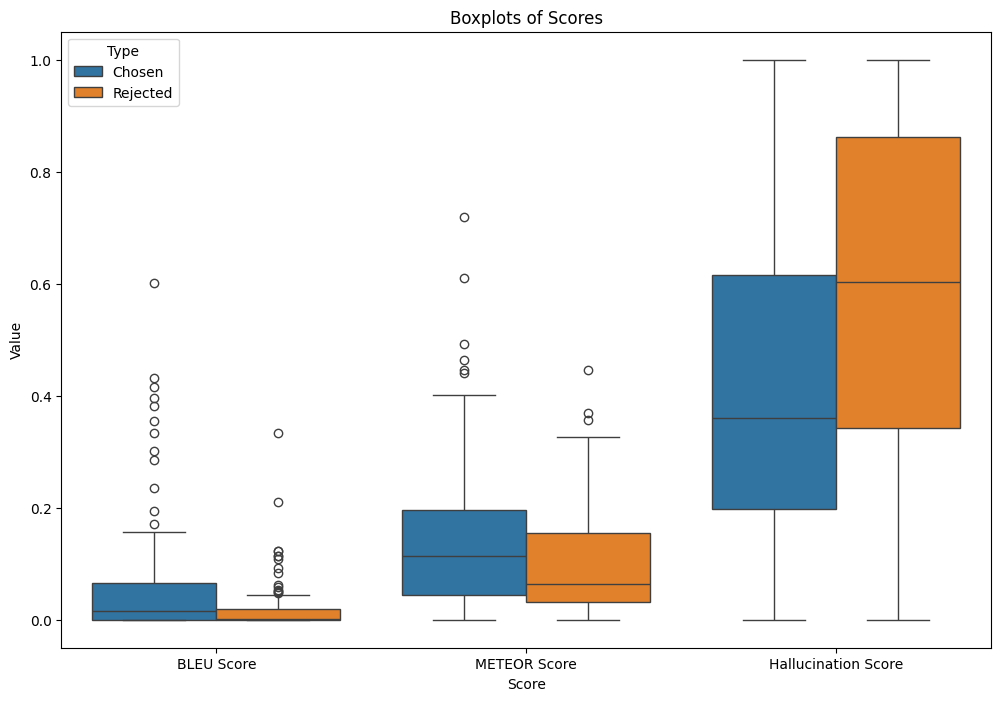

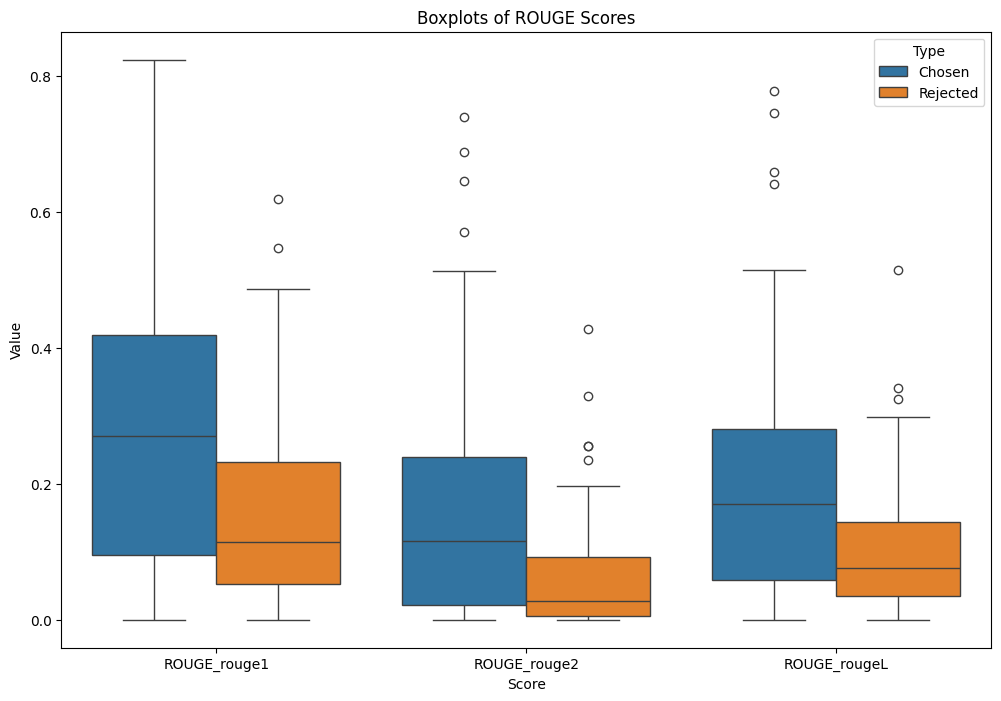

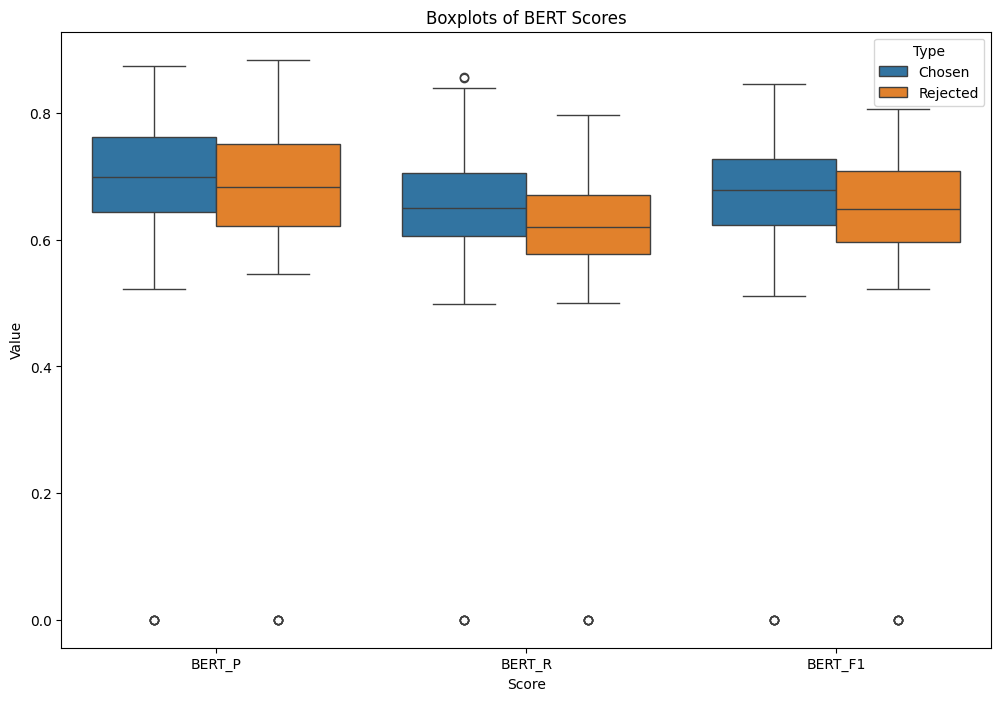

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming results_df is already defined and contains the necessary columns

# Extract the different scores into separate columns
scores = ['BLEU Score', 'ROUGE Scores', 'METEOR Score', 'BERTScore', 'Hallucination Score']
for score in scores:
    results_df[f'chosen_{score}'] = results_df['chosen'].apply(lambda x: x.get(score, None))
    results_df[f'rejected_{score}'] = results_df['rejected'].apply(lambda x: x.get(score, None))

# Expand ROUGE Scores and BERTScore into individual columns
rouge_scores = ['rouge1', 'rouge2', 'rougeL']
bert_scores = ['BERT_P', 'BERT_R', 'BERT_F1']

for rouge in rouge_scores:
    results_df[f'chosen_ROUGE_{rouge}'] = results_df['chosen_ROUGE Scores'].apply(lambda x: x.get(rouge, None) if x else None)
    results_df[f'rejected_ROUGE_{rouge}'] = results_df['rejected_ROUGE Scores'].apply(lambda x: x.get(rouge, None) if x else None)

for i, bert in enumerate(bert_scores):
    results_df[f'chosen_{bert}'] = results_df['chosen_BERTScore'].apply(lambda x: x[i] if x else None)
    results_df[f'rejected_{bert}'] = results_df['rejected_BERTScore'].apply(lambda x: x[i] if x else None)

# Function to create boxplots
def plot_boxplots(df, score_names, title):
    """
    Create and display boxplots for the given scores.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the scores.
    score_names (list): The list of score names to plot.
    title (str): The title of the plot.

    Returns:
    None
    """
    data = []
    for score in score_names:
        chosen_scores = df[f'chosen_{score}'].dropna().tolist()
        rejected_scores = df[f'rejected_{score}'].dropna().tolist()
        data.extend([(score, 'Chosen', value) for value in chosen_scores])
        data.extend([(score, 'Rejected', value) for value in rejected_scores])

    plot_df = pd.DataFrame(data, columns=['Score', 'Type', 'Value'])
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='Score', y='Value', hue='Type', data=plot_df)
    plt.title(title)
    plt.show()

# Plotting boxplots
plot_boxplots(results_df, ['BLEU Score', 'METEOR Score', 'Hallucination Score'], 'Boxplots of Scores')
plot_boxplots(results_df, ['ROUGE_rouge1', 'ROUGE_rouge2', 'ROUGE_rougeL'], 'Boxplots of ROUGE Scores')
plot_boxplots(results_df, ['BERT_P', 'BERT_R', 'BERT_F1'], 'Boxplots of BERT Scores')

# Filter out and save parquet

Number of filtered data points: 76


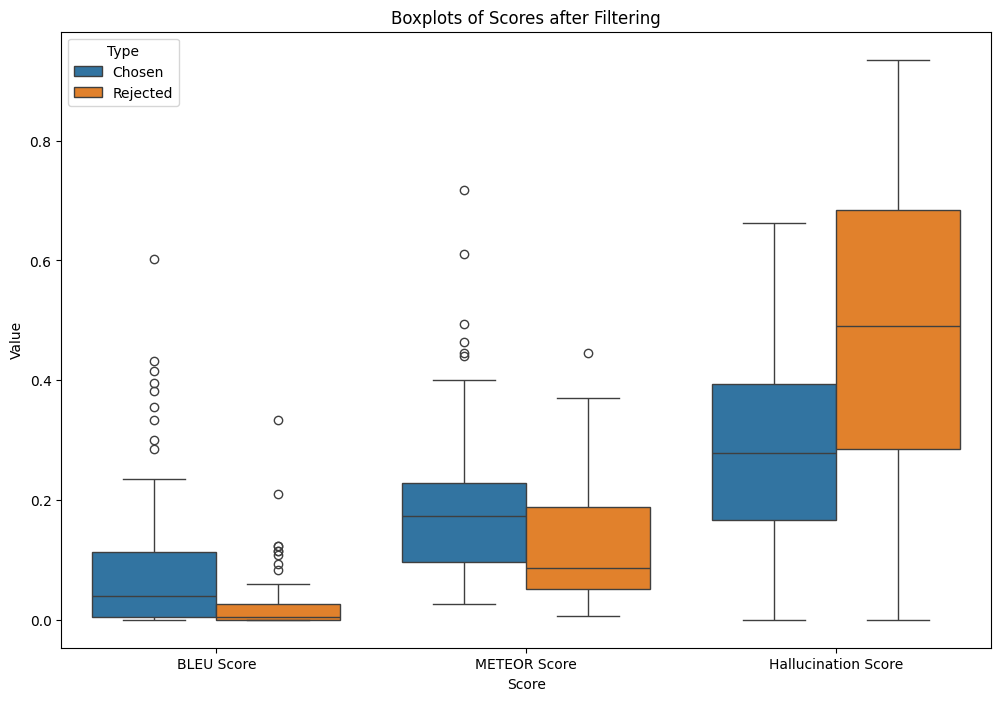

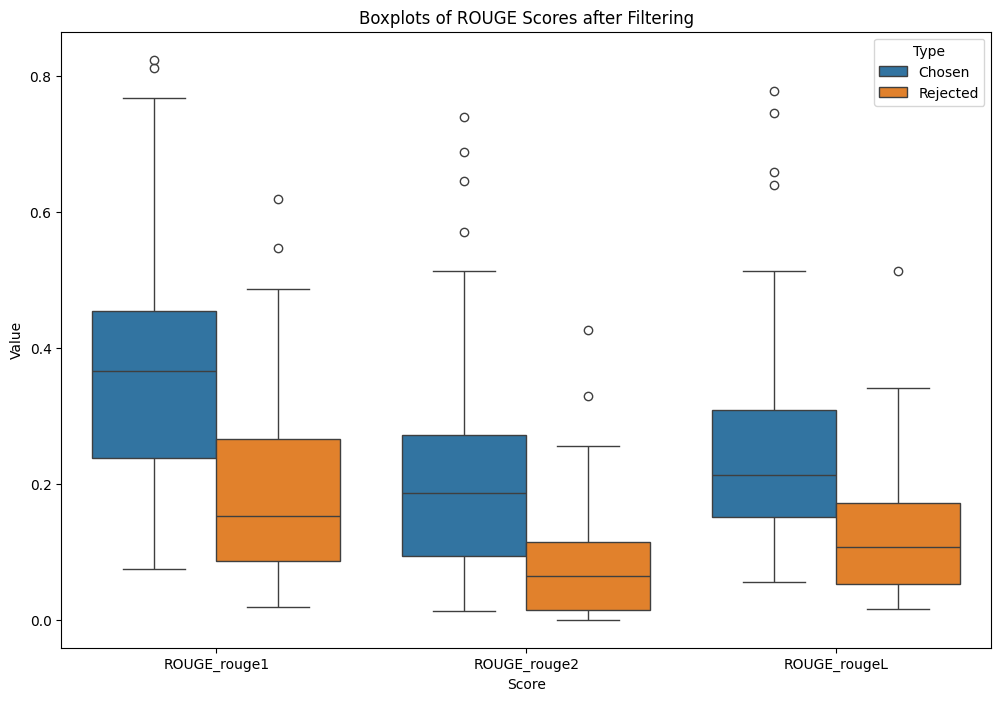

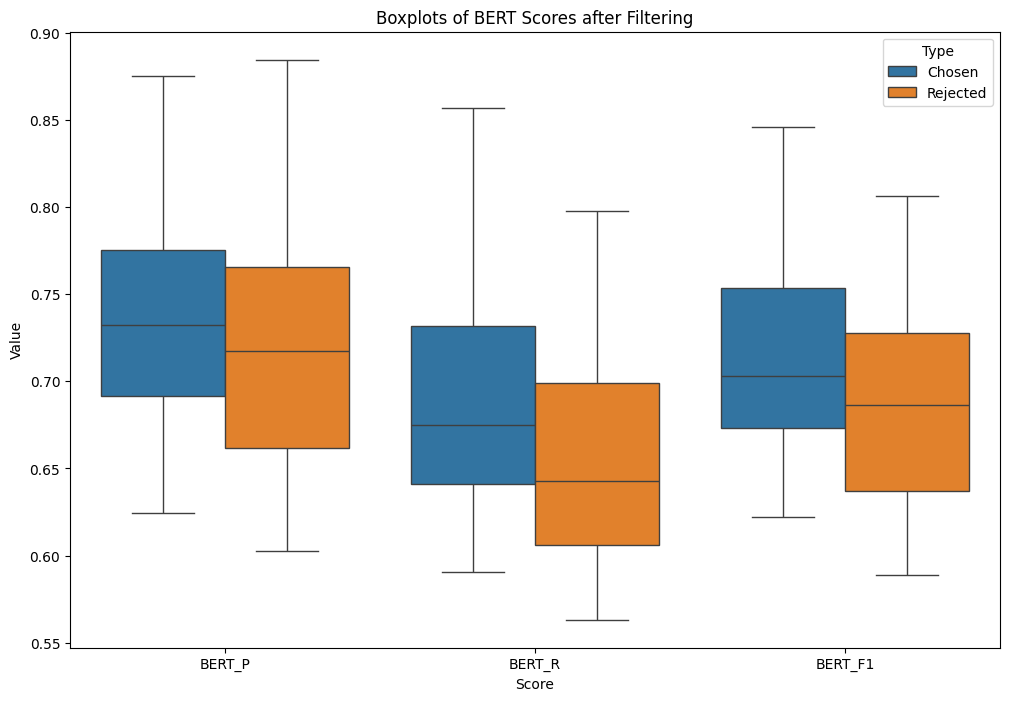

Filtered DataFrame has been saved to 'filtered_output.parquet'.


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

class DataProcessor:
    def __init__(self, results_df, thresholds, score_names, bert_scores):
        """
        Initialize the DataProcessor with given parameters.

        :param results_df: DataFrame containing the results data.
        :param thresholds: Dictionary of threshold values for filtering.
        :param score_names: List of score names to process.
        :param bert_scores: List of BERT score names.
        :param significance_threshold: The threshold for considering a score difference significant.
        """
        self.results_df = results_df
        self.thresholds = thresholds
        self.score_names = score_names
        self.bert_scores = bert_scores

    def is_similar(self, row):
        """
        Check if a row meets the similarity criteria based on thresholds.

        :param row: DataFrame row.
        :return: Boolean indicating if the row meets the criteria.
        """
        chosen = row['chosen']
        if 'BERTScore' in chosen and 'Hallucination Score' in chosen:
            return (chosen['BERTScore'][2] >= self.thresholds['BERT F1'] and
                    chosen['Hallucination Score'] <= self.thresholds['Hallucination Score'])
        return False

    def plot_boxplots(self, df, score_names, title):
        """
        Create and display boxplots for the given scores.

        :param df: DataFrame containing the scores.
        :param score_names: List of score names to plot.
        :param title: Title of the plot.
        """
        data = []
        for score in score_names:
            chosen_scores = df[f'chosen_{score}'].dropna().tolist()
            rejected_scores = df[f'rejected_{score}'].dropna().tolist()
            data.extend([(score, 'Chosen', value) for value in chosen_scores])
            data.extend([(score, 'Rejected', value) for value in rejected_scores])
        plot_df = pd.DataFrame(data, columns=['Score', 'Type', 'Value'])
        plt.figure(figsize=(12, 8))
        sns.boxplot(x='Score', y='Value', hue='Type', data=plot_df)
        plt.title(title)
        plt.show()

    def process(self):
        """
        Process the results DataFrame by filtering based on similarity criteria and removing rows where rejected scores are better.

        :return: Filtered DataFrame.
        """
        # Filter the DataFrame based on similarity criteria
        filtered_results_df = self.results_df[self.results_df.apply(self.is_similar, axis=1)]

        print(f"Number of filtered data points: {len(filtered_results_df)}")

        # Plotting boxplots for the filtered data
        self.plot_boxplots(filtered_results_df, ['BLEU Score', 'METEOR Score', 'Hallucination Score'], 'Boxplots of Scores after Filtering')
        self.plot_boxplots(filtered_results_df, ['ROUGE_rouge1', 'ROUGE_rouge2', 'ROUGE_rougeL'], 'Boxplots of ROUGE Scores after Filtering')
        self.plot_boxplots(filtered_results_df, ['BERT_P', 'BERT_R', 'BERT_F1'], 'Boxplots of BERT Scores after Filtering')

        return filtered_results_df

    def save_filtered_data(self, filtered_df, original_file_path, output_file_path):
        """
        Save the filtered DataFrame to a new parquet file.

        :param filtered_df: Filtered DataFrame to save.
        :param original_file_path: Path to the original parquet file.
        :param output_file_path: Path to save the filtered parquet file.
        """
        # Load the original parquet file
        original_df = pd.read_parquet(original_file_path)

        # Extract the sources from the filtered DataFrame
        remaining_sources = filtered_df['source'].unique()

        # Filter the original DataFrame to include only these sources
        filtered_original_df = original_df[original_df['source'].isin(remaining_sources)]

        # Remove rows where both 'prompt' and 'question' are null/None
        filtered_original_df = filtered_original_df.dropna(subset=['prompt', 'question'], how='all')

        # Save the filtered DataFrame to a new parquet file
        filtered_original_df.to_parquet(output_file_path)
        print(f"Filtered DataFrame has been saved to '{output_file_path}'.")

# Parameters and initialization
thresholds = {
    'BERT F1': 0.61,
    'Hallucination Score': 0.70
}
score_names = ['BLEU Score', 'METEOR Score', 'Hallucination Score', 'ROUGE_rouge1', 'ROUGE_rouge2', 'ROUGE_rougeL', 'BERT_P', 'BERT_R', 'BERT_F1']
bert_scores = ['BERT_P', 'BERT_R', 'BERT_F1']

# Create an instance of the DataProcessor class
processor = DataProcessor(results_df, thresholds, score_names, bert_scores)

# Process the data and get the filtered DataFrame
filtered_results_df = processor.process()

# Save the filtered data to a new parquet file
processor.save_filtered_data(filtered_results_df, "output/output.parquet", 'output/filtered_output.parquet')
